<a href="https://colab.research.google.com/github/sonaliliyanahetti/Final-Year-Research-Malaria-Detection-Models/blob/main/Malaria_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -------------------- IMPORTS --------------------
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import cv2
import os
import gc
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras import layers
import seaborn as sns

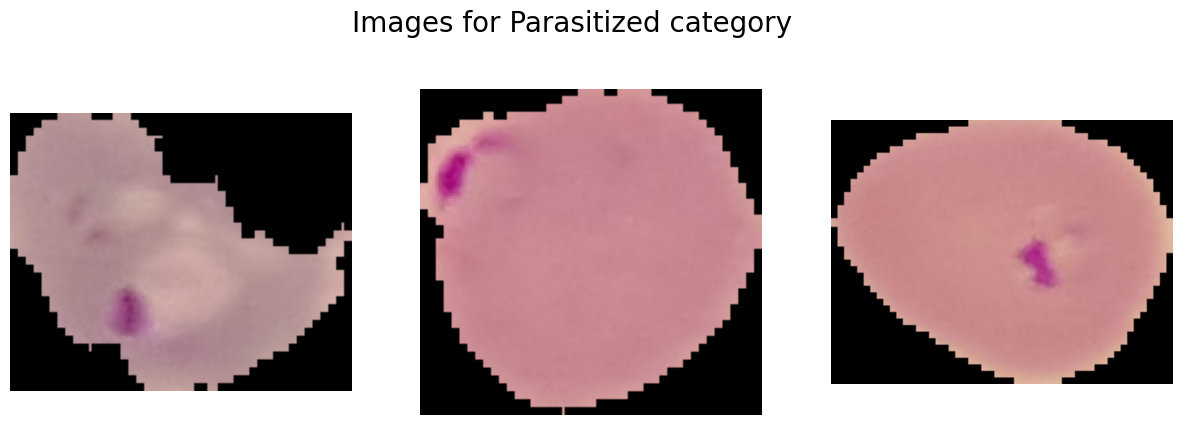

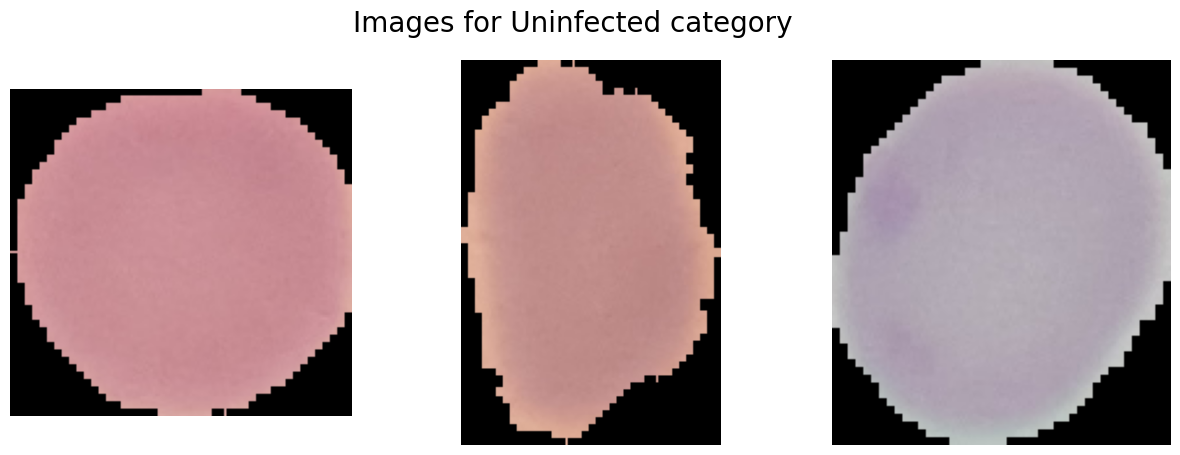

Path exists: True
Folders: ['Parasitized', 'Uninfected']


In [ ]:

# -------------------- DATA EXTRACTION --------------------
data_path = '/content/drive/MyDrive/Research/archive/cell_images/cell_images'
path = data_path
classes = ['Parasitized','Uninfected']

# Display sample images
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

print("Path exists:", os.path.exists(path))
print("Folders:", os.listdir(path))


In [ ]:
# -------------------- DATA PREPROCESSING --------------------
IMG_SIZE = 128
LIMIT = 1000
SPLIT = 0.2

X = []
Y = []

for i, cat in enumerate(classes):
    extensions = ['*.jpeg', '*.jpg', '*.png']
    images = []
    for ext in extensions:
        images.extend(glob(f'{path}/{cat}/{ext}'))

    print(cat, "total images found:", len(images))
    images = images[:LIMIT]
    print(cat, "using images:", len(images))

    for image_path in images:
        img = cv2.imread(image_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img)
        Y.append(i)

X = np.asarray(X)
Y = np.array(Y)

# Train/Validation Split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=SPLIT, random_state=2022)

# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0

# One-hot encode labels
Y_train_one_hot = tf.keras.utils.to_categorical(Y_train, num_classes=len(classes))
Y_val_one_hot = tf.keras.utils.to_categorical(Y_val, num_classes=len(classes))

print("Training samples:", len(X_train))
print("Validation samples:", len(X_val))


Parasitized total images found: 13780
Parasitized using images: 1000
Uninfected total images found: 13779
Uninfected using images: 1000
Training samples: 1600
Validation samples: 400


In [ ]:
# -------------------- RESNET50 TRANSFER LEARNING MODEL --------------------
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augment = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base_model.layers:
    layer.trainable = False  # Freeze pretrained weights

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
output = Dense(len(classes), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,794 (91.99 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.5170 - loss: 0.7992 - val_accuracy: 0.5125 - val_loss: 0.6990
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.5434 - loss: 0.7378 - val_accuracy: 0.5125 - val_loss: 0.6911
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.5359 - loss: 0.7581 - val_accuracy: 0.5675 - val_loss: 0.6872
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.5518 - loss: 0.7145 - val_accuracy: 0.5125 - val_loss: 0.6894
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.5529 - loss: 0.7354 - val_accuracy: 0.5975 - val_loss: 0.6827
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.5662 - loss: 0.7143 - val_accuracy: 0.5125 - val_loss: 0.7332
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.5757 - loss: 0.7018 - val_accuracy: 0.5125 - val_loss: 0.6960
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.5346 - loss: 0.7419 - val_accuracy: 0.5200 - v

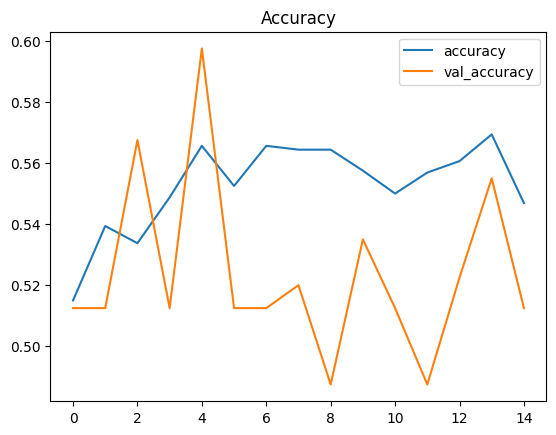

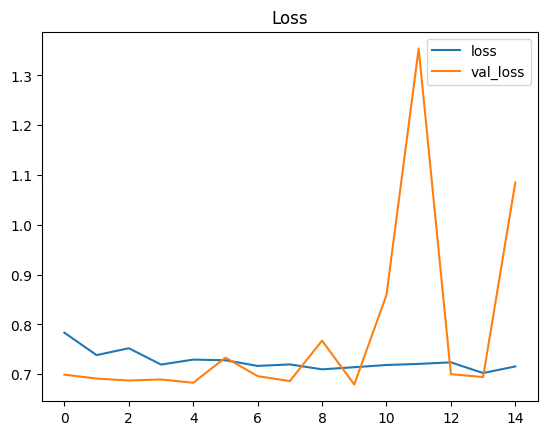

In [ ]:
# -------------------- TRAINING --------------------
history = model.fit(
    augment.flow(X_train, Y_train_one_hot, batch_size=32),
    validation_data=(X_val, Y_val_one_hot),
    epochs=15,
    verbose=1
)

# -------------------- TRAINING GRAPHS --------------------
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

history_df[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step
              precision    recall  f1-score   support

 Parasitized       0.51      1.00      0.68       205
  Uninfected       0.00      0.00      0.00       195

    accuracy                           0.51       400
   macro avg       0.26      0.50      0.34       400
weighted avg       0.26      0.51      0.35       400



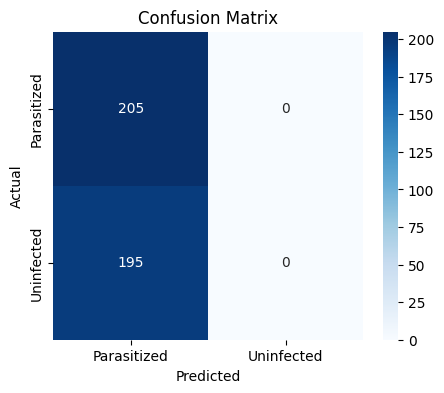

In [ ]:
# -------------------- MODEL EVALUATION --------------------
Y_pred = model.predict(X_val)
Y_pred = np.argmax(Y_pred, axis=1)

print(metrics.classification_report(Y_val, Y_pred, target_names=classes))

cm = confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()